# Stock Price Prediction Using LSTM

## Overview of the process
- fetch the dataset

- preprocess the data

- define the model

- train the model on the dataset

- test the model

## installing the packages

In [ ]:
!pip install yfinance

## importing necesarry libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf

In [ ]:
START = "2020-01-01"
END = date.today().strftime("%Y-%m-%d") # strftime converts datetype from "datetime.date" to 'str'

## function to load dataset

In [ ]:
def fetch_data(ticker):
    data = yf.download(ticker, START, END)
    data.reset_index(inplace=True)
    return data

## loading the dataset of META using the function

In [ ]:
data = fetch_data('META')
df = data
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.349792,12077100
1,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.242081,11188400
2,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.164017,17058900
3,2020-01-07,212.820007,214.580002,211.750000,213.059998,212.623062,14912400
4,2020-01-08,213.000000,216.240005,212.610001,215.220001,214.778641,13475000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1159 non-null   datetime64[ns]
 1   Open       1159 non-null   float64       
 2   High       1159 non-null   float64       
 3   Low        1159 non-null   float64       
 4   Close      1159 non-null   float64       
 5   Adj Close  1159 non-null   float64       
 6   Volume     1159 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 63.5 KB


## visualing the closing price data

Text(0.5, 1.0, " 'Meta Platforms Inc.' stock price")

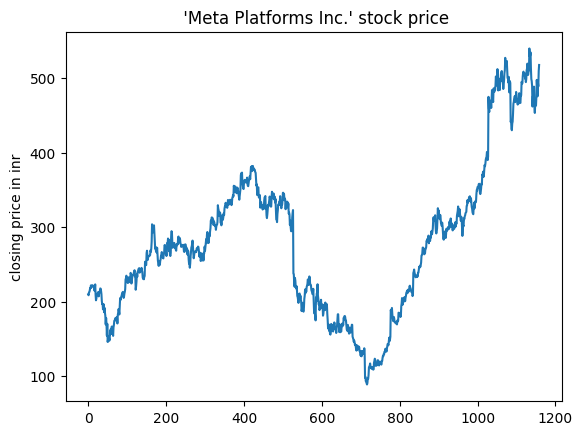

In [ ]:
plt.plot(df['Close'])
plt.ylabel('closing price in inr')
plt.title(" 'Meta Platforms Inc.' stock price")

In [ ]:
df1 = df.reset_index()['Close']
df1

,Close
0,209.779999
1,208.669998
2,212.600006
3,213.059998
4,215.220001
...,...
1154,475.730011
1155,494.089996
1156,488.920013
1157,509.630005


## normalising the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1)) #reshape into a 2d array

In [ ]:
print(df1)
print(type(df1))
print(df1.shape)

[[0.26800444]
 [0.26554324]
 [0.27425723]
 ...
 [0.88694021]
 [0.93286038]
 [0.95090919]]
<class 'numpy.ndarray'>
(1159, 1)


## splitting the data

In [ ]:
TRAIN_SIZE = int(len(df1) * 0.7)
TEST_SIZE = len(df1) - TRAIN_SIZE
print("TRAIN_SIZE :", TRAIN_SIZE, "TEST_SIZE :", TEST_SIZE)

TRAIN_SIZE : 811 TEST_SIZE : 348


In [ ]:
train_data = df1[:TRAIN_SIZE,:]
test_data = df1[TRAIN_SIZE:, :]

In [ ]:
print(train_data.shape)
print(test_data.shape)

(811, 1)
(348, 1)


## create x and y for supervised learning

stock price data = 300 350 345 265 457 368 390

suppose timesteps = 5

Then,

x = [[300 350 345 265 457], [350 345 265 457 368]]

y = [368, 390]

In [ ]:
def create_dataset(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        x = dataset[i: (i + time_step), 0]
        data_X.append(x)
        y = dataset[i + time_step, 0]
        data_Y.append(y)

    return np.array(data_X), np.array(data_Y)

In [ ]:
TIME_STEPS = 60
X_train, Y_train = create_dataset(train_data, TIME_STEPS)
X_test, Y_test = create_dataset(test_data, TIME_STEPS)

In [ ]:
print(X_train.shape, Y_train.shape) # shape of X_train = (train_size - TIME_STEPS, TIME_STEPS), Y_train = (train_size - TIME_STEPS, 1)
print(X_test.shape, Y_test.shape)

(750, 60) (750,)
(287, 60) (287,)


## since LSTM requires a 3D input,  we reshaped input to be [batch_size, time_steps, features]

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(750, 60, 1) (750, 1)
(287, 60, 1) (287, 1)


## defining the LSTM model

In [ ]:
# import the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
model=Sequential()
model.add(LSTM(128, activation = 'relu', return_sequences=True,input_shape=(TIME_STEPS,1)))
model.add(Dropout(0.2))

model.add(LSTM(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(25))

model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           66560     
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117

## training the model on the train data

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.fit(X_train, Y_train, epochs=5)

Epoch 1/5
24/24 [==============================] - 4s 67ms/step - loss: 0.0406 - mean_absolute_error: 0.1509
Epoch 2/5
24/24 [==============================] - 2s 68ms/step - loss: 0.0067 - mean_absolute_error: 0.0650
Epoch 3/5
24/24 [==============================] - 2s 71ms/step - loss: 0.0028 - mean_absolute_error: 0.0406
Epoch 4/5
24/24 [==============================] - 2s 69ms/step - loss: 0.0031 - mean_absolute_error: 0.0418
Epoch 5/5
24/24 [==============================] - 2s 65ms/step - loss: 0.0023 - mean_absolute_error: 0.0345


In [ ]:
model.save('keras_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Y_pred = model.predict(X_test)

9/9 [==============================] - 0s 25ms/step


In [ ]:
print(Y_pred.shape, Y_test.shape)

(287, 1) (287, 1)


In [ ]:
Y_pred = scaler.inverse_transform(Y_pred)
Y_test = scaler.inverse_transform(Y_test)

## Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, Y_pred)
print("mean absolute error: ", mae)

mae_percentage = (mae / np.mean(Y_test)) * 100
print(f"Mean absolute error percentage: {mae_percentage:.2f} %")

mean absolute error:  14.802393471322405
Mean absolute error percentage: 3.74 %


In [ ]:
rmse = np.sqrt(np.mean((Y_pred - Y_test) ** 2))
print(rmse)


21.879387194308173


In [ ]:
print(Y_pred.shape, Y_test.shape)

(287, 1) (287, 1)


In [ ]:
print(Y_test)

[[284.32998657]
 [281.64001465]
 [284.88000488]
 [288.73001099]
 [278.47000122]
 [287.04998779]
 [285.29000854]
 [281.52999878]
 [286.98001099]
 [286.01998901]
 [294.36999512]
 [291.98999023]
 [290.52999878]
 [294.1000061 ]
 [298.29000854]
 [309.33999634]
 [313.41000366]
 [308.86999512]
 [310.61999512]
 [312.04998779]
 [316.01000977]
 [302.51998901]
 [294.26000977]
 [291.60998535]
 [294.47000122]
 [298.57000732]
 [311.70999146]
 [325.48001099]
 [318.6000061 ]
 [322.70999146]
 [314.30999756]
 [313.19000244]
 [310.73001099]
 [316.55999756]
 [312.64001465]
 [305.20999146]
 [305.73999023]
 [301.64001465]
 [306.19000244]
 [301.95001221]
 [294.29000854]
 [285.08999634]
 [283.25      ]
 [289.8999939 ]
 [287.6000061 ]
 [294.23999023]
 [286.75      ]
 [285.5       ]
 [290.26000977]
 [297.98999023]
 [295.1000061 ]
 [295.89001465]
 [296.38000488]
 [300.1499939 ]
 [299.17001343]
 [298.67001343]
 [297.89001465]
 [307.55999756]
 [301.66000366]
 [305.05999756]
 [311.72000122]
 [300.30999756]
 [302.54

## visualising the result

<ipython-input-153-0de5aac6adf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = Y_pred


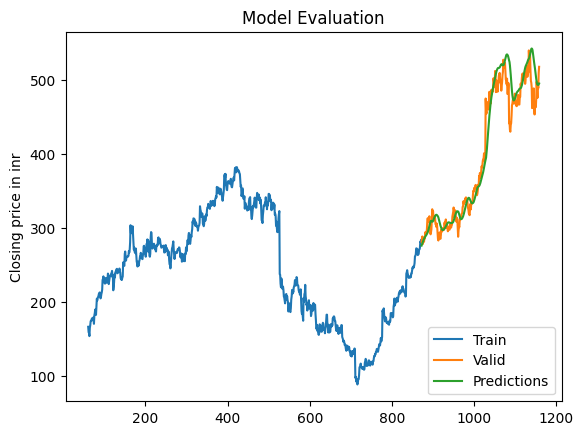

In [ ]:
plot_data = df.filter(['Close'])
train = plot_data.loc[TIME_STEPS + 1 : TRAIN_SIZE + TIME_STEPS + 1]
valid = plot_data.loc[TRAIN_SIZE + TIME_STEPS + 1:]
valid['Prediction'] = Y_pred
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.title('Model Evaluation')
plt.ylabel('Closing price in inr')
plt.show()